In [1]:
from lmfit import minimize, Parameters, fit_report
import lmfit
import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
from emll.aesara_utils import LeastSquaresSolve

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


1. define the equation
2. fill out all the matrices
    - import the data
3. use lmfit to  fit the equation


In [33]:
xn.shape
# len(r.getReactionIds())

(19, 11)

In [35]:
r.getScaledElasticityMatrix().shape
# xn should be 16,11

yn.shape # 3, 16
ey.shape # 16, 3


(16, 3)

In [2]:
# import the data 
df = pd.read_csv('data/Simplified_Teusink_yeast_1.05.csv')

In [3]:
r = te.loada('Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [5]:
v_star = df[fluxes].loc[0]

In [6]:
ex = r.getScaledElasticityMatrix()

In [7]:
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

### testing with one perturbation

### testing with multiple perturbations

In [8]:
en = df[enzymes].loc[1:]/df[enzymes].loc[0]
xn = df[internal].loc[1:]/df[internal].loc[0]
yn = df[external].loc[1:]/df[external].loc[0]
vn = df[fluxes].loc[1:]/df[fluxes].loc[0]

In [9]:
gt_fluxes = df[fluxes].loc[1:].values
inner = np.ones((16,19)) + ex@np.log(xn).T + ey@np.log(yn).T
linlog_fluxes = (np.diag(v_star) @ inner).T

res = linlog_fluxes - gt_fluxes
(res*res).sum().sum()

0.07597613934617567

### using lmfit to predict elasticity values 

In [10]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, yn, v_star, df, *args, **kws):
    
    some_list = []
    Ex_params = [i for i in params if 'Ex' in i]
    for i in Ex_params:
        some_list.append(params[i])
    ex = np.asarray(some_list).reshape((16,11))
    some_list = []
    Ey_params = [i for i in params if 'Ey' in i]
    for i in Ey_params:
        some_list.append(params[i])
    ey = np.asarray(some_list).reshape((16,3)) 

    model = np.diag(v_star)@(np.ones((16,19)) + ex@np.log(xn).T + ey@np.log(yn).T)

    return (df[fluxes].loc[1:].values-model.T)

params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)
for i in range(16*(3)):
    params.add('Ey'+str(i), value=0, min=-10, max=10)

itervalues = []
out = minimize(residual, params, args=(xn, yn, v_star, df), iter_cb=cb, kws={'itervalues': itervalues})
# out = minimize(residual, params, args=(xn, yn, v_star, df), method='differential_evolution', iter_cb=cb, kws={'itervalues': itervalues})

-1 0.020138152325099808
0 0.020138152325099808
1 0.020138152325099808
2 0.020137188161505712
3 0.020137421844349277
4 0.020137328450030904
5 0.020137320955921013
6 0.020137377940770942
7 0.020137397763649215
8 0.020137434155259027
9 0.020137484449036947
10 0.020137560115328395
11 0.020137700041912426
12 0.020137851839046397
13 0.020138018610309654
14 0.02013803408365121
15 0.020137977172875385
16 0.020137953705562504
17 0.020137935729919166
18 0.020137928235549545
19 0.02013792904224086
20 0.020137938535253586
21 0.020137961608497644
22 0.020138002344423988
23 0.020138048531210415
24 0.020138148166484546
25 0.02013814838334107
26 0.02013814839214618
27 0.020138148621625974
28 0.020138149260534245
29 0.020138149498481403
30 0.020138149756489154
31 0.020138150010111103
32 0.0201381502848463
33 0.020138150818419583
34 0.020138151373482287
35 0.020138080283803556
36 0.02013810425762065
37 0.020138107886524776
38 0.020138112606142684
39 0.0201381227231727
40 0.020138126531634264
41 0.020138

In [11]:
out.chisqr

0.011003870190673764

## Ex values predicted by lmfit when guesses were initialized at 0

In [12]:
Ex_values = [out.params.get(i).value for i in params if 'Ex' in i]
Ey_values = [out.params.get(i).value for i in params if 'Ey' in i]
Ex_values = np.array(Ex_values).reshape((16,11))
Ey_values = np.array(Ey_values).reshape((16,3))

In [13]:
pd.DataFrame(Ex_values, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())

,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,0.141755,0.124794,0.011876,0.001753,0.040343,0.005291,0.006480,0.009698,-0.001149,0.005970,0.025643
vPGI,0.021513,0.053403,0.038144,0.006096,0.133497,0.017375,0.021305,0.031978,-0.003643,0.019839,0.085300
vGLYCO,0.031533,0.910356,-0.001042,-0.000182,-0.003973,-0.000516,-0.000635,-0.000959,0.000105,-0.000600,-0.002583
vTreha,0.265874,0.115237,-0.011620,-0.002151,-0.043126,-0.005530,-0.006797,-0.010259,0.001079,-0.006460,-0.027826
vPFK,0.021513,0.053403,0.038144,0.006096,0.133497,0.017375,0.021305,0.031978,-0.003643,0.019839,0.085300
vALD,0.021513,0.053403,0.038144,0.006096,0.133497,0.017375,0.021305,0.031978,-0.003643,0.019839,0.085300
vGAPDH,0.017753,0.047587,0.032393,0.005190,-0.007828,0.023663,0.029104,0.043779,-0.004969,0.027205,0.117048
vPGK,0.017753,0.047587,0.032393,0.005190,-0.007828,0.023663,0.029104,0.043779,-0.004969,0.027205,0.117048
vPGM,0.017753,0.047587,0.032393,0.005190,-0.007828,0.023663,0.029104,0.043779,-0.004969,0.027205,0.117048
vENO,0.017753,0.047587,0.032393,0.005190,-0.007828,0.023663,0.029104,0.043779,-0.004969,0.027205,0.117048


## Ey values predicted by lmfit when guesses were initialized at 0

In [14]:
pd.DataFrame(Ey_values, index=r.getReactionIds())

,0,1,2
vGLK,0.123533,0.0,0.0
vPGI,0.018827,0.0,0.0
vGLYCO,0.023969,0.0,0.0
vTreha,0.231966,0.0,0.0
vPFK,0.018827,0.0,0.0
vALD,0.018827,0.0,0.0
vGAPDH,0.016089,0.0,0.0
vPGK,0.016089,0.0,0.0
vPGM,0.016089,0.0,0.0
vENO,0.016089,0.0,0.0


## Trying to see if we can get lmfit to predict the actual elasticity values by initializing the guesses with ground truth

In [15]:
# flatten the matrix 
ex_seeds = r.getScaledElasticityMatrix().flatten()
ey_seeds = ey.flatten()

s_params = Parameters()

for i in range(16*(11)):
    s_params.add('Ex'+str(i), value=ex_seeds[i]+ 0.05*ex_seeds[i], min=-10, max=10)
for i in range(16*(3)):
    s_params.add('Ey'+str(i), value=ey_seeds[i]+ 0.05*ey_seeds[i], min=-10, max=10)

s_out = minimize(residual, s_params, args=(xn, yn, v_star, df))

In [16]:
# s_out

In [17]:
s_out.chisqr

0.011003870190673625

## Ex values predicted by lmfit when guesses were initialized with ground truth elasticity values

In [18]:
s_Ex_values = [s_out.params.get(i).value for i in params if 'Ex' in i]
s_Ey_values = [s_out.params.get(i).value for i in params if 'Ey' in i]
s_Ex_values = np.array(s_Ex_values).reshape((16,11))
s_Ey_values = np.array(s_Ey_values).reshape((16,3))

In [19]:
pd.DataFrame(s_Ex_values, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())

,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,0.141755,0.124794,0.011876,0.001753,0.040343,0.005291,0.006480,0.009698,-0.001149,0.005970,0.025643
vPGI,0.021513,0.053403,0.038144,0.006096,0.133497,0.017375,0.021305,0.031978,-0.003643,0.019839,0.085300
vGLYCO,0.031533,0.910356,-0.001041,-0.000184,-0.003972,-0.000516,-0.000636,-0.000958,0.000105,-0.000600,-0.002583
vTreha,0.265874,0.115237,-0.011620,-0.002151,-0.043126,-0.005530,-0.006797,-0.010260,0.001080,-0.006460,-0.027826
vPFK,0.021513,0.053403,0.038144,0.006096,0.133497,0.017375,0.021305,0.031978,-0.003643,0.019839,0.085300
vALD,0.021513,0.053403,0.038144,0.006096,0.133497,0.017375,0.021305,0.031978,-0.003643,0.019839,0.085300
vGAPDH,0.017753,0.047587,0.032393,0.005190,-0.007828,0.023663,0.029104,0.043779,-0.004969,0.027205,0.117048
vPGK,0.017753,0.047587,0.032393,0.005190,-0.007828,0.023663,0.029104,0.043779,-0.004969,0.027205,0.117048
vPGM,0.017753,0.047587,0.032393,0.005190,-0.007828,0.023663,0.029104,0.043779,-0.004969,0.027205,0.117048
vENO,0.017753,0.047587,0.032393,0.005190,-0.007828,0.023663,0.029104,0.043779,-0.004969,0.027205,0.117048


## Ey values predicted by lmfit when guesses were initialized with ground truth elasticity values

In [20]:
pd.DataFrame(s_Ey_values, index=r.getReactionIds())

,0,1,2
vGLK,0.123533,0.0,0.0
vPGI,0.018827,0.0,0.0
vGLYCO,0.023969,0.0,0.0
vTreha,0.231966,0.0,0.0
vPFK,0.018827,0.0,0.0
vALD,0.018827,0.0,0.0
vGAPDH,0.016089,0.0,0.0
vPGK,0.016089,0.0,0.0
vPGM,0.016089,0.0,0.0
vENO,0.016089,0.0,0.0


## Calculating the chi square of the ground truth values in the loss function

In [21]:
((linlog_fluxes - gt_fluxes)*(linlog_fluxes - gt_fluxes)).sum().sum()

0.07597613934617567

In [22]:
s_out.chisqr # <-- lmfit found a way to minimize the loss function even more with different values

0.011003870190673625

## Calculating the values of chi-square while varying the number of Ex values fit, given Ey. 

In [23]:
r = te.loada('Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [24]:
en = df[enzymes].loc[1:]/df[enzymes].loc[0]
xn = df[internal].loc[1:]/df[internal].loc[0]
yn = df[external].loc[1:]/df[external].loc[0]
vn = df[fluxes].loc[1:]/df[fluxes].loc[0]

In [25]:
ex = r.getScaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

In [26]:
# where does the ground truth have nonzero values?
nonzeros = np.where(r.getScaledElasticityMatrix().flatten()!=0)[0]
ex_seeds = r.getScaledElasticityMatrix().flatten()

In [27]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, yn, v_star, ex, ey, df, coords, *args, **kws):

    for i in coords:
        ex[i] = params[f'Ex{i}']

    ex = ex.reshape((16,11))
    a = np.ones((16,19))
    b = ex@np.log(xn).T
    c = ey@np.log(yn).T

    model = np.diag(v_star)@(a + b + c)
    return (df[fluxes].loc[1:].values-model.T)

In [28]:
chisq_list=[]
param_list = []
# for each nonzero elasticity
for i in range(len(nonzeros)):
    # for each elasticity up to that nonzero elasticity
    params = Parameters()
    for ii in nonzeros[:(i+1)]:
        # define parameters for the run
        # add all the nonzero parameters
        params.add(f'Ex{ii}', value=ex_seeds[ii], min=-10, max=10)
    coords = [ii for ii in nonzeros[:(i+1)]]
    # out = minimize(residual, params, args=(xn, yn, v_star, ex.flatten(), ey, df, coords), method='differential_evolution', iter_cb=cb)
    out = minimize(residual, params, args=(xn, yn, v_star, ex.flatten(), ey, df, coords))
    chisq_list.append(out.chisqr)
    param_list.append(out.params)

ValueError: x and y must be the same size

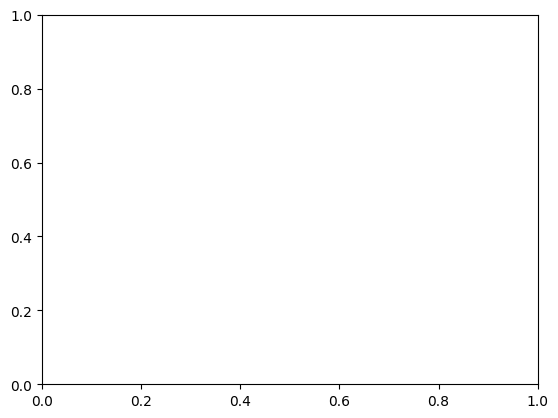

In [29]:
plt.figure()
plt.scatter(np.arange(1,25,1), np.array(chisq_list))
plt.grid()
plt.title('chisqr values as the number of nonzero elasticity value\
          parameters are increased')
plt.xlabel('nonzero elasticity value parameters')
plt.ylabel('chisqr')


In [ ]:
r.getScaledElasticityMatrix()

                GLCi,      G6P,       F6P,     F16P,      TRIO, BPG,      P3G,      P2G,       PEP,      PYR,        ACE
vGLK   [[ -0.0290019, 0.193638,        -0,       -0,        -0,  -0,       -0,       -0,        -0,       -0,         -0],
vPGI    [          0, 0.381264, -0.241208,        0,         0,   0,        0,        0,         0,        0,          0],
vGLYCO  [          0,        1,         0,        0,         0,   0,        0,        0,         0,        0,          0],
vTreha  [          0,        1,         0,        0,         0,   0,        0,        0,         0,        0,          0],
vPFK    [         -0,       -0, -0.911996, 0.987411,        -0,  -0,       -0,       -0,        -0,       -0,         -0],
vALD    [          0,        0,         0,  0.25501, -0.183274,   0,        0,        0,         0,        0,          0],
vGAPDH  [          0,        0,         0,        0,  0.342466,  -0,        0,        0,         0,        0,          0],
vPGK    [         

In [ ]:
a = 0.5
b = 0.2

ax + by = 1
ax + by + cz= 1

In [ ]:
param_list[10]

name,value,standard error,relative error,initial value,min,max,vary
Ex0,0.20215382,0.13994816,(69.23%),-0.029001918996360905,-10.0000000,10.0000000,True
Ex1,0.19619473,0.17927025,(91.37%),0.19363802053991291,-10.0000000,10.0000000,True
Ex12,0.13799913,0.33802361,(244.95%),0.3812635623818447,-10.0000000,10.0000000,True
Ex13,0.16861093,0.24679854,(146.37%),-0.24120759400833422,-10.0000000,10.0000000,True
Ex23,0.94923340,2.22342081,(234.23%),1.0000000000000053,-10.0000000,10.0000000,True
Ex34,0.44312862,0.43501710,(98.17%),0.9999999999999967,-10.0000000,10.0000000,True
Ex46,0.12198849,0.29254396,(239.81%),-0.9119961769486226,-10.0000000,10.0000000,True
Ex47,0.13216237,0.26285316,(198.89%),0.9874106564131484,-10.0000000,10.0000000,True
Ex58,0.07503004,0.23164574,(308.74%),0.2550098866592161,-10.0000000,10.0000000,True
Ex59,0.20093570,0.24009806,(119.49%),-0.18327393895902858,-10.0000000,10.0000000,True


In [ ]:
param_list[23]

name,value,standard error,relative error,initial value,min,max,vary
Ex0,0.20215382,0.09664374,(47.81%),-0.029001918996360905,-10.0000000,10.0000000,True
Ex1,0.19619473,0.12379832,(63.10%),0.19363802053991291,-10.0000000,10.0000000,True
Ex12,0.13799913,0.23342833,(169.15%),0.3812635623818447,-10.0000000,10.0000000,True
Ex13,0.16861093,0.17043121,(101.08%),-0.24120759400833422,-10.0000000,10.0000000,True
Ex23,0.94923340,1.53542355,(161.75%),1.0000000000000053,-10.0000000,10.0000000,True
Ex34,0.44312862,0.30040894,(67.79%),0.9999999999999967,-10.0000000,10.0000000,True
Ex46,0.12198848,0.20202154,(165.61%),-0.9119961769486226,-10.0000000,10.0000000,True
Ex47,0.13216236,0.18151802,(137.34%),0.9874106564131484,-10.0000000,10.0000000,True
Ex58,0.07503004,0.15996717,(213.20%),0.2550098866592161,-10.0000000,10.0000000,True
Ex59,0.20093570,0.16580407,(82.52%),-0.18327393895902858,-10.0000000,10.0000000,True


In the results above, ey was fixed and ex parameters were initialized with groundtruth values. 

In [ ]:
# ground truth
b = np.ones((16,19)) + ex@np.log(xn).T + ey@np.log(yn).T
dif = (np.diag(v_star) @ b).T - df[fluxes].loc[1:].values
(dif*dif).sum().sum()

0.03349427218525486

In [ ]:
ex[0,1] = 0.43760147

b = np.ones((16,19)) + ex@np.log(xn).T + ey@np.log(yn).T
dif = (np.diag(v_star) @ b).T - df[fluxes].loc[1:].values
print((dif*dif).sum().sum())

ex = r.getScaledElasticityMatrix()

0.03297137014327055


Now, we are going to explore control coefficient values for each set of elasticity values predicted by lmfit

In [ ]:
# copy+pasted then adapted from BMCA-pipeline/util

n_exp = en.shape[0]

e_star = df[enzymes].iloc[0].values
x_star = df[internal].iloc[0].values
y_star = df[external].iloc[0].values
v_star = df[fluxes].iloc[0].values

def elasticity_to_CCC(BMCA, scaledE=None):

    if scaledE is None:
        scaledE = BMCA.Ex

    r = te.loada(BMCA.model_file)
    r.conservedMoietyAnalysis = True
    r.steadyState()
    link_matrix = r.getLinkMatrix()
    Nr = r.getReducedStoichiometryMatrix()

    ##### this line needs to be workshopped
    unscaledE = np.linalg.inv(np.diag(1/BMCA.v_star)) @ scaledE @ np.linalg.inv(np.diag(BMCA.x_star))

    invJac = np.linalg.inv(-Nr@unscaledE@link_matrix)
    idMat = np.identity(len(BMCA.v_star))

    # unscaled concentration and flux control coefficients, respectively
    Cx = link_matrix@invJac@Nr 
    CJ = np.matmul(unscaledE, Cx) + idMat # unscaled FCC

    # scaled concentration and flux control coefficients, respectively  
    ##### these two lines need to be workshopped
    CxS = np.diag(1/BMCA.x_star) @ Cx @ np.diag(BMCA.v_star)
    CJS = np.diag(1/BMCA.v_star) @ CJ @ np.diag(BMCA.v_star)

    return CxS, CJS

def estimate_CCs(Ex):
    vn[vn == 0] = 1e-6
    
    a = np.diag(en.values / vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1, axis=0)

    Ex_ss = a @ Ex
    As = N @ np.diag(v_star) @ Ex_ss
    bs = N @ np.diag(v_star)
    bs = bs[np.newaxis, :].repeat(1, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(N.T))
    identity = identity[np.newaxis,:].repeat(1, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC

In [ ]:
# [[i[ii].value for ii in i.keys()] for i in param_list]
lmfit_values = [param_list[-1][ii].value for ii in param_list[-1].keys()]
ex = r.getScaledElasticityMatrix()
FCC_list = []

for i in param_list:
    # make replacement in groundtruth ex at the proper location
    
    ex_replaced = ex.flatten()
    for ii in nonzeros[:len(param_list[0].keys())]:
        ex_replaced[ii] = lmfit_values[ii]
    ex_replaced = ex_replaced.reshape((16,11))
    FCC_list.append(estimate_CCs(ex_replaced))

In [ ]:
fcc_list=np.array(FCC_list)
fcc_list = fcc_list.squeeze()

In [ ]:
fcc_list[0][0]

array([ 1.98952372e+00,  7.48778460e-04,  1.58632890e-04,  1.62158065e-03,
       -1.97345258e-04,  7.63749528e-04,  2.96366204e-04, -3.85912192e-03,
        3.10942457e-03,  3.53181274e-04, -4.63872830e-04,  6.62664386e-04,
        2.19822851e-05, -9.92832385e-01,  5.29863734e-05,  3.96616094e-05])

In [ ]:
fcc_list[1][0]

array([ 1.98952372e+00,  7.48778460e-04,  1.58632890e-04,  1.62158065e-03,
       -1.97345258e-04,  7.63749528e-04,  2.96366204e-04, -3.85912192e-03,
        3.10942457e-03,  3.53181274e-04, -4.63872830e-04,  6.62664386e-04,
        2.19822851e-05, -9.92832385e-01,  5.29863734e-05,  3.96616094e-05])

In [ ]:
fcc_list[23][0]

array([ 1.98952372e+00,  7.48778460e-04,  1.58632890e-04,  1.62158065e-03,
       -1.97345258e-04,  7.63749528e-04,  2.96366204e-04, -3.85912192e-03,
        3.10942457e-03,  3.53181274e-04, -4.63872830e-04,  6.62664386e-04,
        2.19822851e-05, -9.92832385e-01,  5.29863734e-05,  3.96616094e-05])

In [ ]:
r.getScaledFluxControlCoefficientMatrix()[0]

[1.97827702e-01 5.10757773e-02 1.89554933e-02 1.93767264e-01
 3.51968189e-02 3.29828174e-02 1.58676664e-02 1.20388199e-02
 8.49372163e-03 5.19193084e-03 5.57501480e-03 3.47188097e-03
 2.80782735e-04 4.06810162e-01 6.76802198e-04 1.17873451e-02]

the FCC values are all the same for each lmfit run. 

Could this be due to the fact that the Ex values were all the same for each lmfit run? 

## Using a stochastic method

In [ ]:
chisq_list=[]
param_list = []
# for each nonzero elasticity
for i in range(len(nonzeros)):
    # for each elasticity up to that nonzero elasticity
    params = Parameters()
    for ii in nonzeros[:(i+1)]:
        # define parameters for the run
        # add all the nonzero parameters
        params.add(f'Ex{ii}', value=ex_seeds[ii], min=-10, max=10)
    coords = [ii for ii in nonzeros[:(i+1)]]
    
    out = minimize(residual, params, args=(xn, yn, v_star, ex.flatten(), ey, df, coords), method='differential_evolution')
    chisq_list.append(out.chisqr)
    param_list.append(out.params)

In [ ]:
param_list[4]

name,value,initial value,min,max,vary
Ex0,0.20215552,-0.029001918996360905,-10.0000000,10.0000000,True
Ex1,0.19619323,0.19363802053991291,-10.0000000,10.0000000,True
Ex12,0.13799299,0.3812635623818447,-10.0000000,10.0000000,True
Ex13,0.16860828,-0.24120759400833422,-10.0000000,10.0000000,True
Ex23,0.94919925,1.0000000000000053,-10.0000000,10.0000000,True


In [ ]:
param_list[10]

name,value,initial value,min,max,vary
Ex0,0.20223775,-0.029001918996360905,-10.0000000,10.0000000,True
Ex1,0.19610925,0.19363802053991291,-10.0000000,10.0000000,True
Ex12,0.13799225,0.3812635623818447,-10.0000000,10.0000000,True
Ex13,0.16859488,-0.24120759400833422,-10.0000000,10.0000000,True
Ex23,0.94911425,1.0000000000000053,-10.0000000,10.0000000,True
Ex34,0.44293444,0.9999999999999967,-10.0000000,10.0000000,True
Ex46,0.12201776,-0.9119961769486226,-10.0000000,10.0000000,True
Ex47,0.13176921,0.9874106564131484,-10.0000000,10.0000000,True
Ex58,0.07529242,0.2550098866592161,-10.0000000,10.0000000,True
Ex59,0.20078768,-0.18327393895902858,-10.0000000,10.0000000,True


Text(0, 0.5, 'chisqr')

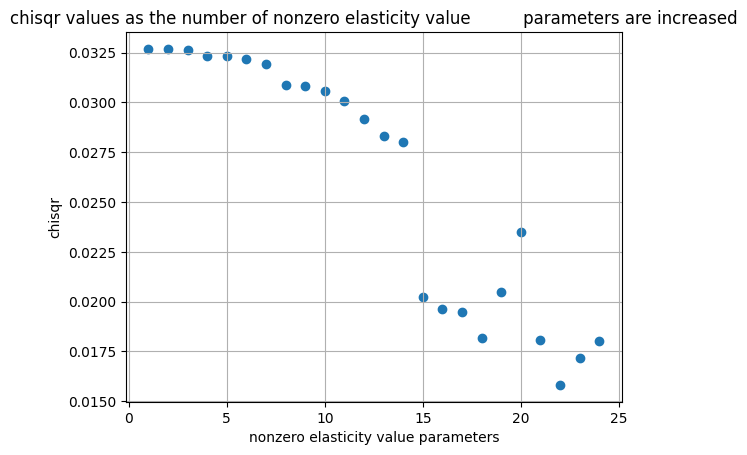

In [ ]:
plt.figure()
plt.scatter(np.arange(1,25,1), np.array(chisq_list))
plt.grid()
plt.title('chisqr values as the number of nonzero elasticity value\
          parameters are increased')
plt.xlabel('nonzero elasticity value parameters')
plt.ylabel('chisqr')


In [ ]:
# [[i[ii].value for ii in i.keys()] for i in param_list]
lmfit_values = [param_list[-1][ii].value for ii in param_list[-1].keys()]
ex = r.getScaledElasticityMatrix()
FCC_list = []

for i in param_list:
    # make replacement in groundtruth ex at the proper location
    
    ex_replaced = ex.flatten()
    for ii in nonzeros[:len(param_list[0].keys())]:
        ex_replaced[ii] = lmfit_values[ii]
    ex_replaced = ex_replaced.reshape((16,11))
    FCC_list.append(estimate_CCs(ex_replaced))

In [ ]:
fcc_list=np.array(FCC_list)
fcc_list = fcc_list.squeeze()

In [ ]:
fcc_list[1][0]

array([ 1.99268411e+00,  5.33883383e-04,  1.10397530e-04,  1.12850808e-03,
       -1.40708313e-04,  5.44557841e-04,  2.25134729e-04, -3.85404416e-03,
        3.10533325e-03,  3.52716565e-04, -4.63262476e-04,  6.61792465e-04,
        2.19533612e-05, -9.94986710e-01,  5.29166550e-05,  2.34255442e-05])

In [ ]:
fcc_list[23][0]

array([ 1.99268411e+00,  5.33883383e-04,  1.10397530e-04,  1.12850808e-03,
       -1.40708313e-04,  5.44557841e-04,  2.25134729e-04, -3.85404416e-03,
        3.10533325e-03,  3.52716565e-04, -4.63262476e-04,  6.61792465e-04,
        2.19533612e-05, -9.94986710e-01,  5.29166550e-05,  2.34255442e-05])